In [1]:
import torch
import pandas as pd
import ollama
import warnings
import pymysql
import time
import itertools
import re
import matplotlib.pyplot as plt
import plotly.express as px

print("CUDA Version:", torch.version.cuda)
warnings.filterwarnings("ignore")

CUDA Version: 11.8


In [2]:
db = pymysql.connect(
	host='localhost',
    port=3306,
    user='root',
    passwd='jeminist1029',
    db='zabbix_ver1',
    charset='utf8'
    )

cursor = db.cursor()

In [3]:
host_list_df = pd.read_excel("C:\CCraft\i-works\Data\zabbix_host_목록_2.xlsx")

In [4]:
# 특정 column의 특정 값something이 있는 행들을 찾는 sql문을 만드는 함수
def FindSomething(table_name,column_name,something):
  
  table_name = 'history_uint' if table_name == '*' else table_name 
  if column_name=='*' or something=='*':
    return warnings.warn('Given input include '*'')
  sql = f'''
    SELECT *
    FROM {table_name}
    WHERE {column_name} = {something}
  '''
  return sql

#키워드로 hostid 결정
def find_hostid(host_list_df):
  keywords = input("찾고 싶은 서버에 대한 키워드 입력: ")
  rows_contain_keywords = host_list_df[host_list_df['result__name'].str.contains(keywords)]
  print(rows_contain_keywords['result__name'])
  choosen = int(input("원하는 서버의 인덱스 번호를 입력해 주십시오"))
  result = host_list_df.iloc[choosen]['result__hostid']
  print(f"{host_list_df.iloc[choosen]['result__name']}의 hostid는 {result}입니다.")
  return int(result)

def does_it_exist(conn, table,itemid):
    """
    테이블에서 itemid의 존재 여부를 확인합니다.
    존재하면 True, 없으면 False를 반환합니다.
    """
    cur = conn.cursor()
    query = f"""
        SELECT EXISTS(
            SELECT 1
            FROM {table}
            WHERE itemid = {itemid}
        ) AS row_exists;
    """
    cur.execute(query)
    result = cur.fetchone()[0]
    cur.close()
    return bool(result)

def exist_data(conn, itemid):
    """
    itemid가 존재하는 테이블을 확인합니다.
    - history에 있으면 1
    - history_uint에 있으면 2
    - 둘 다 없으면 0을 반환합니다.
    """
    if does_it_exist(conn, 'history',itemid):
        return 1
    elif does_it_exist(conn,'history_uint',itemid):
        return 2
    else:
        return 0

In [15]:
# 1. SQL 문법 검사
def check_sql_syntax(sql):
    try:
        cursor.execute(f"EXPLAIN {sql}")  # SQL 문법 검증
        return True
    except Exception as e:
        print(f"SQL 문법 오류: {e}")
        return False

# 2. itemid와 tablecode 매칭 검사
def make_tablecode_right(sql, dic):
    # itemid 찾기
    itemid_match = re.search(r'itemid\s*=\s*(\d+)', sql)
    table_match = re.search(r'FROM\s+(\w+)', sql, re.IGNORECASE)

    if not itemid_match or not table_match:
        return False, "❌ SQL에서 itemid 또는 테이블명이 없음"

    itemid = itemid_match.group(1)  # 추출된 itemid
    table = table_match.group(1)  # 추출된 테이블명

    # dic에서 올바른 tablecode 찾기
    for key, value in dic.items():
        tablecode, dic_itemid = value.split('_')
        if dic_itemid == itemid:
            expected_table = "history" if tablecode == "1" else "history_uint"
            if expected_table == table:
                return True, sql
            else:
                if sql[57:62] =='_uint': # history를 history_uint라고 잘못 적었을 경우
                    sql = sql[:56]+sql[61:]
                else:
                    sql = sql[:56] + '_uint' + sql[57:]
    return True, sql


In [5]:
# hostid = find_hostid(host_list_df)
hostid = 10464

In [6]:
query_from_hostid = FindSomething('items','hostid',hostid)
print(query_from_hostid)

cursor.execute("SELECT * FROM items LIMIT 1")
items_column_names = [desc[0] for desc in cursor.description]

cursor.execute(query_from_hostid)
result = cursor.fetchall()

df_from_hostid = pd.DataFrame(result, columns=items_column_names)
df_from_hostid = df_from_hostid[['itemid','hostid','name','description']]


    SELECT *
    FROM items
    WHERE hostid = 10464
  


In [7]:
df_from_hostid.head()

,itemid,hostid,name,description
0,40330,10464,Host name of Zabbix agent running,
1,40331,10464,Zabbix agent ping,The agent always returns 1 for this item. It c...
2,40332,10464,Version of Zabbix agent running,
3,40370,10464,Bashlog,
4,40371,10464,Bootlog,


In [8]:
dic = {}
for index, value in enumerate(df_from_hostid['itemid']):
  checker = exist_data(db, value)
  if checker == 1:
    dic[str(df_from_hostid['name'][index])] = '_'.join(('1',str(value)))
  elif checker == 2:
    dic[str(df_from_hostid['name'][index])] = '_'.join(('2',str(value)))

In [9]:
dict(itertools.islice(dic.items(), 5))

{'Zabbix agent ping': '2_40331',
 'Maximum number of open file descriptors': '2_40333',
 'Maximum number of processes': '2_40334',
 'Interface eth0: Inbound packets discarded': '2_42267',
 'Interface eth0: Inbound packets with errors': '2_42269'}

In [10]:
Nowtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
str(Nowtime)

'2025-04-03 16:47:51'

In [11]:
USERs_Question = input("질문을 입력하세요 :")

In [12]:
prompt = {
'Users_Question': USERs_Question,
'Searchable_infomation' : dic,
'Time_now' : time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
}

In [16]:
prompt

{'Users_Question': '사용가능한 메모리 양을 백분율로 알려줘',
 'Searchable_infomation': {'Zabbix agent ping': '2_40331',
  'Maximum number of open file descriptors': '2_40333',
  'Maximum number of processes': '2_40334',
  'Interface eth0: Inbound packets discarded': '2_42267',
  'Interface eth0: Inbound packets with errors': '2_42269',
  'Interface eth0: Bits received': '2_42271',
  'Interface eth1: Inbound packets discarded': '2_42268',
  'Interface eth1: Inbound packets with errors': '2_42270',
  'Interface eth1: Bits received': '2_42272',
  'Interface eth0: Outbound packets discarded': '2_42273',
  'Interface eth0: Outbound packets with errors': '2_42275',
  'Interface eth0: Bits sent': '2_42277',
  'Interface eth1: Outbound packets discarded': '2_42274',
  'Interface eth1: Outbound packets with errors': '2_42276',
  'Interface eth1: Bits sent': '2_42278',
  '18629 Port Check': '2_55756',
  'Number of processes': '2_40335',
  'Number of running processes': '2_40336',
  'System boot time': '2_40337',

In [14]:
response = ollama.chat(model='Makint_Query_version5', messages=[
    {
        'role': 'user',
        'content': str(prompt)
    },
])

LLMresult = response['message']['content']
print(LLMresult)

SELECT itemid, value, FROM_UNIXTIME(clock)
FROM history
WHERE itemid = 40367
AND FROM_UNIXTIME(clock) BETWEEN '2025-04-03 13:48:05' AND '2025-04-03 16:48:05';


In [17]:

is_valid_sql = check_sql_syntax(LLMresult)
is_correct_mapping, SQL_made = make_tablecode_right(LLMresult, dic)
if is_valid_sql and is_correct_mapping:
    print("SQL 문법과 itemid-tablecode 매칭이 올바름")
elif is_valid_sql==True and is_correct_mapping==False:
    print("SQL 터짐")

SQL 문법과 itemid-tablecode 매칭이 올바름


In [18]:
print(SQL_made)

SELECT itemid, value, FROM_UNIXTIME(clock)
FROM history
WHERE itemid = 40367
AND FROM_UNIXTIME(clock) BETWEEN '2025-04-03 13:48:05' AND '2025-04-03 16:48:05';


In [19]:
# 현재 가지고 있는 데이터 테스트 시간을 고려한 임시 시간
testtime = "'2025-02-20 15:02:59' AND '2025-02-21 15:02:59'"

if SQL_made[57:62] == '_uint':
  tmp_sql = SQL_made[:117] + testtime
else:
  tmp_sql = SQL_made[:112] + testtime

print(tmp_sql)

SELECT itemid, value, FROM_UNIXTIME(clock)
FROM history
WHERE itemid = 40367
AND FROM_UNIXTIME(clock) BETWEEN'2025-02-20 15:02:59' AND '2025-02-21 15:02:59'


In [20]:
cursor.execute(tmp_sql)
result = cursor.fetchall()
result[:5]

((40367, 40.725414, datetime.datetime(2025, 2, 20, 15, 3, 47)),
 (40367, 40.717146, datetime.datetime(2025, 2, 20, 15, 4, 47)),
 (40367, 40.716776, datetime.datetime(2025, 2, 20, 15, 5, 47)),
 (40367, 40.733115, datetime.datetime(2025, 2, 20, 15, 6, 47)),
 (40367, 40.731239, datetime.datetime(2025, 2, 20, 15, 7, 47)))

In [21]:
df = pd.DataFrame(result,columns=['itemid','value','clock'])
for_sampledf = df
df.head()

,itemid,value,clock
0,40367,40.725414,2025-02-20 15:03:47
1,40367,40.717146,2025-02-20 15:04:47
2,40367,40.716776,2025-02-20 15:05:47
3,40367,40.733115,2025-02-20 15:06:47
4,40367,40.731239,2025-02-20 15:07:47


In [ ]:
#df.to_pickle("df.pkl")

In [136]:
itemid_of_indicator = df.iloc[0,0]
name_of_indicator =  df_from_hostid.loc[df_from_hostid['itemid'] == itemid_of_indicator, 'name'].iloc[0]

In [137]:
timeset = (df.iloc[-1][2]-df.iloc[0][2]).seconds

In [138]:
str(df['clock'].loc[0])

'2025-02-20 15:03:46'

In [139]:
df_describe= df['value'].describe()
df_describe

count    1.440000e+03
mean     6.760307e+09
std      1.447284e+07
min      6.438031e+09
25%      6.756995e+09
50%      6.761718e+09
75%      6.765192e+09
max      6.779630e+09
Name: value, dtype: float64

In [140]:
print(f"{timeset//60//60}시간 {timeset//60%60}분 동안의 {name_of_indicator}에 대한 지표는 다음과 같습니다.")
print(f"평균: {df_describe[1]} | 표준편차: {df_describe[2]} | 최대값: {df_describe[7]} | 최소값: {df_describe[3]}")

23시간 59분 동안의 Available memory에 대한 지표는 다음과 같습니다.
평균: 6760307043.555555 | 표준편차: 14472842.042776905 | 최대값: 6779629568.0 | 최소값: 6438031360.0


In [141]:
for_sampledf.set_index('clock', inplace=True)
for_sampledf = for_sampledf['value'].resample('H').mean()

In [86]:
for_sampledf.tolist()

[1.1578947368421053,
 1.2,
 1.1666666666666667,
 1.1,
 1.1666666666666667,
 1.2,
 1.1833333333333333,
 1.1666666666666667,
 1.1333333333333333,
 1.25,
 1.1666666666666667,
 1.2666666666666666,
 1.1,
 1.1833333333333333,
 1.2333333333333334,
 1.1166666666666667,
 1.2166666666666666,
 1.1166666666666667,
 1.2333333333333334,
 1.0166666666666666,
 1.15,
 1.05,
 1.25,
 1.2,
 1.6666666666666667]

TypeError: 'NoneType' object is not subscriptable

In [ ]:

# 2. 시간별 평균 값 계산 (분 단위로)
df.set_index('clock', inplace=True)
resampled_df = df['value'].resample('H').mean()
print("\n시간별 평균 값:")
print(resampled_df)

기초 통계 분석:
count    1440.000000
mean        1.168750
std         0.434759
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: value, dtype: float64

값의 빈도 분석:
value
1    1223
2     197
3      16
4       3
6       1
Name: count, dtype: int64

시간별 평균 값:
clock
2025-02-20 15:03:00    1.0
2025-02-20 15:04:00    2.0
2025-02-20 15:05:00    1.0
2025-02-20 15:06:00    1.0
2025-02-20 15:07:00    1.0
                      ... 
2025-02-21 14:58:00    1.0
2025-02-21 14:59:00    1.0
2025-02-21 15:00:00    2.0
2025-02-21 15:01:00    2.0
2025-02-21 15:02:00    1.0
Freq: min, Name: value, Length: 1440, dtype: float64


In [25]:
unit_of_pointer_sql = f"""
SELECT units
FROM items
WHERE itemid = {itemid_of_indicator}
"""

In [26]:
print(unit_of_pointer_sql)


SELECT units
FROM items
WHERE itemid = 40336



In [27]:
cursor.execute(unit_of_pointer_sql)
unit_of_pointer = cursor.fetchall()
unit_of_pointer

(('',),)

In [32]:
fig = px.scatter(df, x ='clock' ,y='value', trendline="ols")
fig.show()

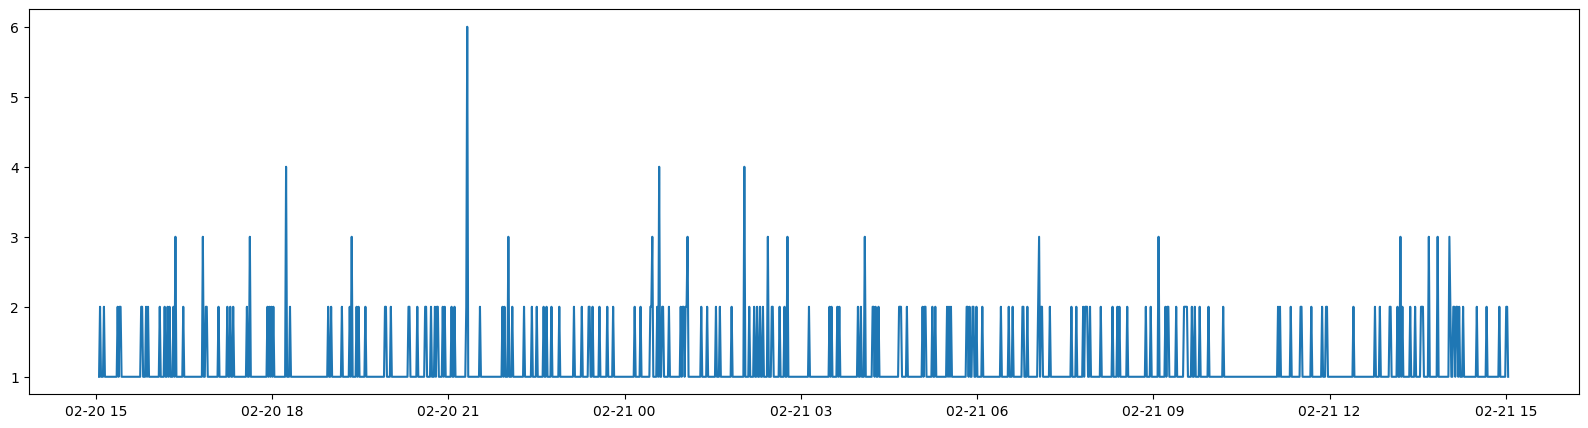

In [28]:
plt.figure(figsize=(20,5))
plt.plot(df['clock'],df['value'])